In [91]:
import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

from unet import UNet

from transformers import MaskTransformer

import torchvision.transforms as T

from matplotlib.patches import Polygon

from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution
from captum.attr import visualization as viz

In [4]:
model = UNet(in_channels=3, n_classes=2, wf=5, depth=4, padding=True, up_mode='upsample')
model.load_state_dict(torch.load("state_dicts/checkpoint.pth"))
model.eval()

UNet(
  (down_path): ModuleList(
    (0): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (1): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (2): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (3): ReLU()
      )
    )
    (3): UNetConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
        (2): Conv2d(256,

In [115]:
transform = T.Compose([
            T.ToPILImage(),
            T.Resize(128),
            T.ToTensor(),
        ])

In [116]:
test = np.array(Image.open("goBoards/board_61.jpg"))
t = transform(test).view(1,3,128,128)

res = model(t).detach().cpu()

out_max = torch.argmax(res, dim=1, keepdim=True)

In [117]:
def agg_segmentation_wrapper(inp):
    model_out = model(inp)
    # Creates binary matrix with 1 for original argmax class for each pixel
    # and 0 otherwise. Note that this may change when the input is ablated
    # so we use the original argmax predicted above, out_max.
    selected_inds = torch.zeros_like(model_out[0:1]).scatter_(1, out_max, 1)
    return (model_out * selected_inds).sum(dim=(2,3))

In [118]:
lgc = LayerGradCam(agg_segmentation_wrapper, model.last)
gc_attr = lgc.attribute(t, target=1)

upsampled_gc_attr = LayerAttribution.interpolate(gc_attr,test.reshape(1,3,800,800).shape[2:])

/home/luan/anaconda3/envs/jupyterlab-debugger/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


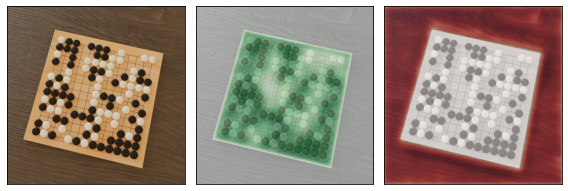

(<Figure size 576x432 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc0b0292730>,
       dtype=object))

In [119]:
viz.visualize_image_attr_multiple(upsampled_gc_attr[0].cpu().permute(1,2,0).detach().numpy(),original_image=test,signs=["all", "positive", "negative"],methods=["original_image", "blended_heat_map","blended_heat_map"])

In [120]:
mt = MaskTransformer(model, 128)

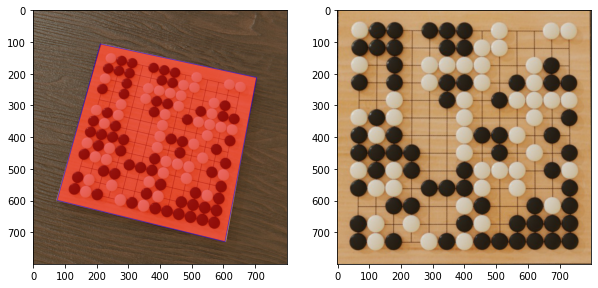

In [121]:
with torch.no_grad():
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,10))
    res = model(t).cpu()[0][0].numpy()
    
    img, mask, poly = mt.transform(test)
    
    p = Polygon(poly[:,0,:], facecolor = 'r', alpha=0.5, edgecolor = "b")
    ax2.imshow(img)
    ax1.imshow(test)
    ax1.add_patch(p)